# Импорты и настройки

In [10]:
import shutil
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

# Загрузка данных

In [11]:
ds_local_dir = Path("chest_xray")

if not ds_local_dir.exists():
    ds_folder_path = kagglehub.dataset_download(
        "paultimothymooney/chest-xray-pneumonia"
    )  # загрузим данные
    print(f"Dataset saved to: {ds_folder_path}")

    ds_dir = Path(ds_folder_path) / "chest_xray" / "chest_xray"

    ds_dir.rename(ds_local_dir)  # перенесём данные в текущую директорию
    shutil.rmtree(
        Path(ds_folder_path).parent.parent.parent
    )  # удалим датасет из директории kagglehub
print(f"Dataset saved to: {ds_local_dir}")

100%|██████████████████████████████████████████████████████████████████████████████████████| 2.29G/2.29G [01:00<00:00, 40.9MB/s]

Extracting files...


Dataset saved to: /home/nortlite/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Dataset saved to: chest_xray


# EDA
Для начала посмотрим в директорию `train` и `test`, директорию `val` рассматривать не будем, т.к. там всего по 8 элементов категории больных и здоровых, я добавил эти снимки в тренировочную выборку.

В наборе данных со снимками лёгких с пневмонией видно что категория "больные" делится ещё на две подгруппы `virus` и `bacteria`, очевидно снимки лёгких с вирусной и бактериальной пневмонией.

Для удобства составления датасета для обучения и валидации я разделю данные следующим образом: все снимки здоровых лёгких я помещу в директорию `normal`. Снимки с бактериальной пневмонией поместим в директорию `bacteria` а снимки с вирусной пневмонией в директорию `virus`.

In [12]:
data_dir = Path("chest_xray")
train_dir = data_dir / "train"
test_dir = data_dir / "test"
val_dir = data_dir / "val"

# перенесём все снимки без заболеваний из val директороии в train
for file in (val_dir / "NORMAL").glob("*.jpeg"):
    file.rename(train_dir / "NORMAL" / file.name)
# перенесём все снимки больными лёгкими из val директороии в train
for file in (val_dir / "PNEUMONIA").glob("*.jpeg"):
    file.rename(train_dir / "PNEUMONIA" / file.name)

# создадим директории normal, virus и bacteria в train и test директориях
train_normal_dir = train_dir / "NORMAL"
train_normal_dir = train_normal_dir.rename(train_dir / "normal")
train_bacteria_dir = train_dir / "bacteria"
train_bacteria_dir.mkdir(exist_ok=True, parents=True)
train_virus_dir = train_dir / "virus"
train_virus_dir.mkdir(exist_ok=True, parents=True)

test_normal_dir = test_dir / "NORMAL"
test_normal_dir = test_normal_dir.rename(test_dir / "normal")
test_bacteria_dir = test_dir / "bacteria"
test_bacteria_dir.mkdir(exist_ok=True, parents=True)
test_virus_dir = test_dir / "virus"
test_virus_dir.mkdir(exist_ok=True, parents=True)

# перенесём соответствующие снимки по соответствующим директориям
for file in (train_dir / "PNEUMONIA").glob("*_bacteria_*.jpeg"):
    file.rename(train_bacteria_dir / file.name)

for file in (train_dir / "PNEUMONIA").glob("*_virus_*.jpeg"):
    file.rename(train_virus_dir / file.name)

for file in (test_dir / "PNEUMONIA").glob("*_bacteria_*.jpeg"):
    file.rename(test_bacteria_dir / file.name)

for file in (test_dir / "PNEUMONIA").glob("*_virus_*.jpeg"):
    file.rename(test_virus_dir / file.name)

# удалим ненужные директории
shutil.rmtree(train_dir / "PNEUMONIA")
shutil.rmtree(test_dir / "PNEUMONIA")
shutil.rmtree(val_dir)

Посмотрим каково распределение классов в данных для обучения и в тестовых данных:

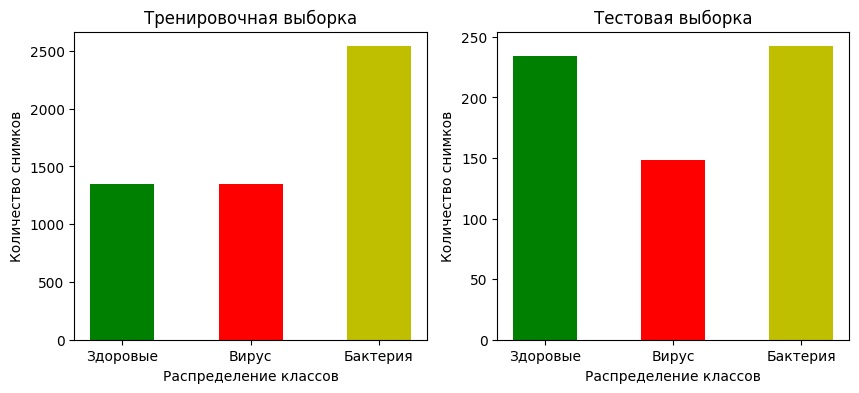

In [13]:
train_0_count = len(list(train_normal_dir.glob("*.jpeg")))
train_1_count = len(list(train_virus_dir.glob("*.jpeg")))
train_2_count = len(list(train_bacteria_dir.glob("*.jpeg")))

test_0_count = len(list(test_normal_dir.glob("*.jpeg")))
test_1_count = len(list(test_virus_dir.glob("*.jpeg")))
test_2_count = len(list(test_bacteria_dir.glob("*.jpeg")))

fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
ax[0].bar(0, train_0_count, width=0.25, color="g")
ax[0].bar(0.5, train_1_count, width=0.25, color="r")
ax[0].bar(1, train_2_count, width=0.25, color="y")
ax[0].set_ylabel("Количество снимков")
ax[0].set_xlabel("Распределение классов")
ax[0].set_xticks([0, 0.5, 1], ["Здоровые", "Вирус", "Бактерия"])
ax[0].set_title("Тренировочная выборка")

ax[1].bar(0, test_0_count, width=0.25, color="g")
ax[1].bar(0.5, test_1_count, width=0.25, color="r")
ax[1].bar(1, test_2_count, width=0.25, color="y")
ax[1].set_ylabel("Количество снимков")
ax[1].set_xlabel("Распределение классов")
ax[1].set_xticks([0, 0.5, 1], ["Здоровые", "Вирус", "Бактерия"])
ax[1].set_title("Тестовая выборка")
plt.show()

Как можем заметить присутствует дисбаланс классов - снимков с бактериальной пневмонией немногим менее чем в 2 раза больше. Попробуем пока не убирать данный дисбаланс; если далее мы поймём что это повлияет на качество обученной модели - то попробуем немного сократить количество снимков с бактериальной пневмонией.

Отобразим несколько изображений из тренировочного датасета, для этого сначала составим объекты тренировочного и тестового датасета. Сразу добавим слой нормализации изображений, для приведения значени от `[0 - 255]` к `[0 - 1]`.

Found 5232 files belonging to 3 classes.


I0000 00:00:1750372332.908745  176620 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12979 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 624 files belonging to 3 classes.


2025-06-20 00:32:13.605607: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


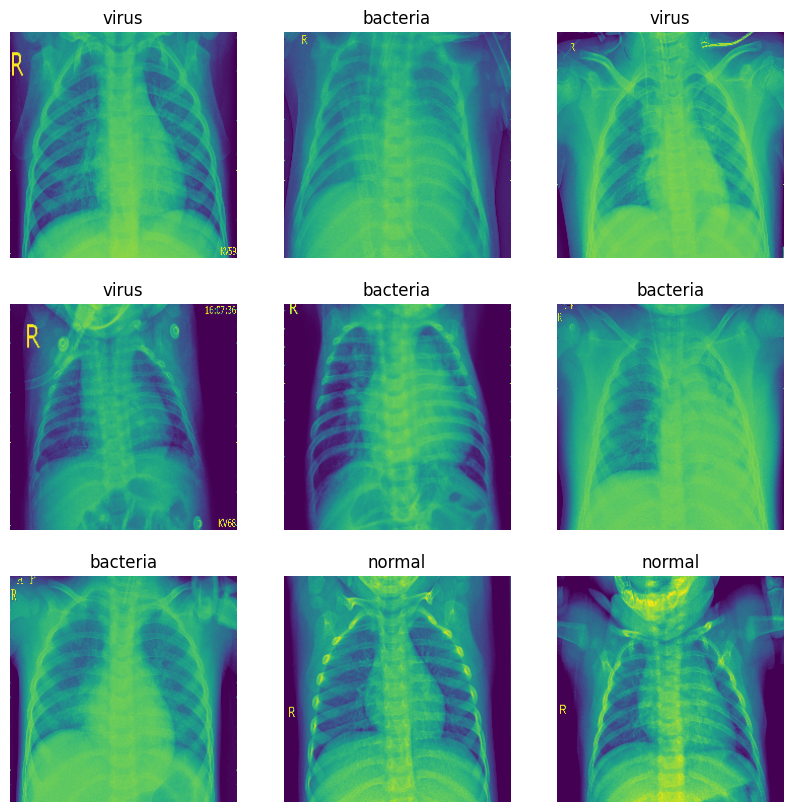

In [14]:
# тренировочный датасет
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=32,
    seed=42,
    color_mode="grayscale",
    image_size=(224, 224),  # преобразование изображение к размеру 224 x 224
    label_mode="categorical",
    shuffle=True
)

# тестовый датасет
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    seed=42,
    color_mode="grayscale",
    image_size=(224, 224),  # преобразование изображение к размеру 224 x 224
    label_mode="categorical",
    shuffle=True
)


fig, axs = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
for X, y in train_ds.take(1):
    for i in range(9):
        axs[i // 3][i % 3].imshow(X[i].numpy())
        axs[i // 3][i % 3].set_title(train_ds.class_names[y[i].numpy().argmax()])
        axs[i // 3][i % 3].axis("off")

plt.show()

# слой нормализации изображений, что бы значения изображений были в диапазоне от 0 до 1
normalization_layer = tf.keras.layers.Rescaling(1. / 127.5, offset=-1)

# Добавим нормализацию и аугментации к тренировочным данным
# слой для рандомного горизонтального "флипа" изображения
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(
        "horizontal",
        seed=42,
    ),  # только горизонтальный флип, кажется что производить переворачивание изображения снизу-вверх нет смысла
    tf.keras.layers.RandomRotation(
        (-0.1, 0.1),
        seed=42
    ),  # поворот на -10/10 %
])


# Тренировка базовой модели

Для начала добавим кастомные метрики Precision, Recall, F1-Score, т.к. в фреймворке tensorflow нет готовой реализации для многоклассовой классификации:

In [15]:
class OneHotPrecision(tf.keras.metrics.Precision):
    def __init__(self, num_classes, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Top-1 → one-hot
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes)
        super().update_state(y_true, y_pred, sample_weight)


class OneHotRecall(tf.keras.metrics.Recall):
    def __init__(self, num_classes, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes)
        super().update_state(y_true, y_pred, sample_weight)


class F1Score(tf.keras.metrics.Metric):
    """Micro-F1 через Micro-Precision и Micro-Recall."""
    def __init__(self, num_classes, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = OneHotPrecision(num_classes)
        self.recall = OneHotRecall(num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * p * r / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [16]:
model = tf.keras.Sequential(
    [
        normalization_layer,
        data_augmentation_layer,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # количество классов - 3
    ]
)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.metrics.CategoricalAccuracy(name='accuracy'),
        OneHotPrecision(3),
        OneHotRecall(3),
        F1Score(3),
        tf.keras.metrics.AUC(
            multi_label=True,
            num_labels=3,
            name="roc_auc"
        ),
    ]
)

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=10
)

model.summary()

Epoch 1/10


I0000 00:00:1750372335.723245  180206 cuda_dnn.cc:529] Loaded cuDNN version 90300


164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5751 - f1: 0.5751 - loss: 4.9639 - precision: 0.5751 - recall: 0.5751 - roc_auc: 0.6652 - val_accuracy: 0.7756 - val_f1: 0.7756 - val_loss: 0.6360 - val_precision: 0.7756 - val_recall: 0.7756 - val_roc_auc: 0.9026
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7298 - f1: 0.7298 - loss: 0.5957 - precision: 0.7298 - recall: 0.7298 - roc_auc: 0.8581 - val_accuracy: 0.7019 - val_f1: 0.7019 - val_loss: 0.7072 - val_precision: 0.7019 - val_recall: 0.7019 - val_roc_auc: 0.8836
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7537 - f1: 0.7537 - loss: 0.5653 - precision: 0.7537 - recall: 0.7537 - roc_auc: 0.8722 - val_accuracy: 0.7692 - val_f1: 0.7692 - val_loss: 0.6202 - val_precision: 0.7692 - val_recall: 0.7692 - val_roc_auc: 0.8883
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7563 - f1: 0.7563 - loss: 0.5553 - precision: 0.7563 - recall: 0.7563 - roc_auc: 0.8800 - val_accurac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,402,955 (577.56 MB)

 Trainable params: 50,467,651 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,935,304 (385.04 MB)

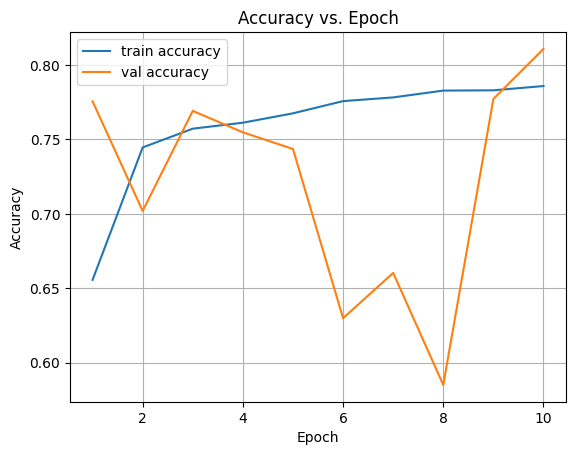

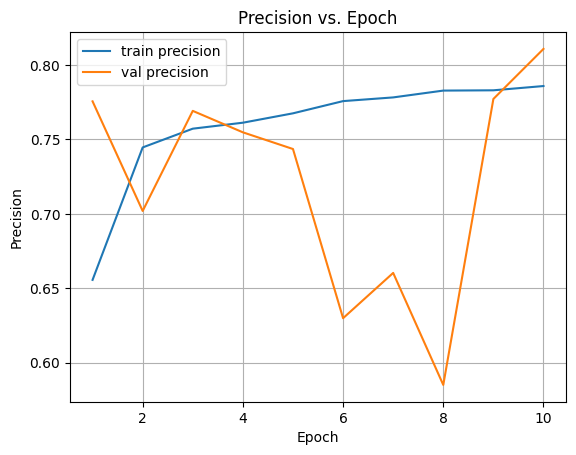

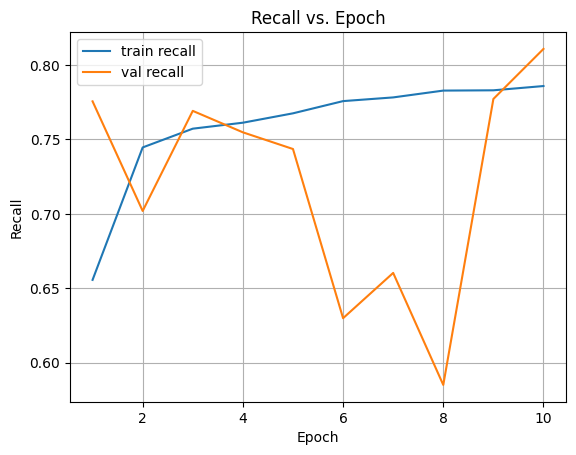

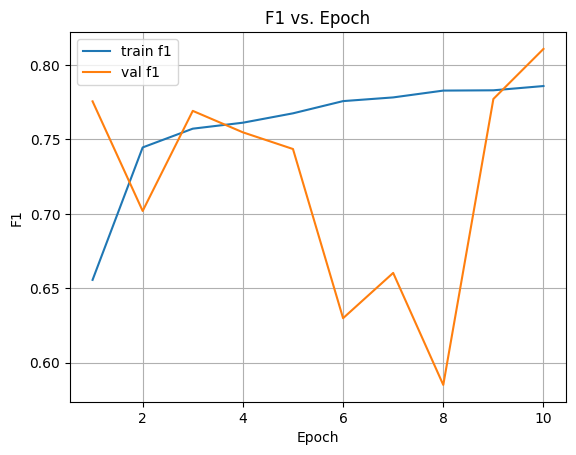

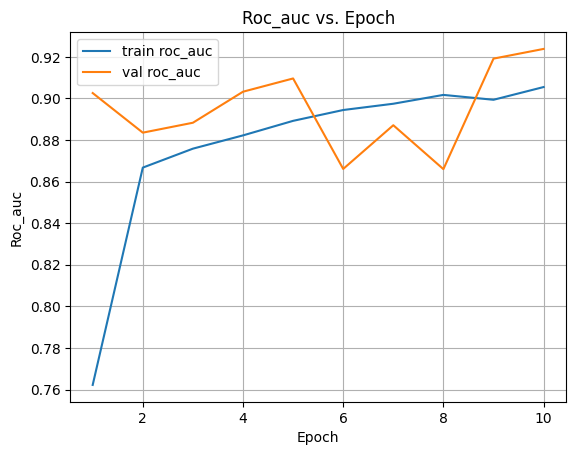

In [18]:
epochs = range(1, 11)
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plt.figure()
    plt.plot(epochs, history.history[metric],         label=f"train {metric}")
    plt.plot(epochs, history.history[f"val_{metric}"], label=f"val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} vs. Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# Более продвинутая модель

In [24]:
BATCH_SIZE   = 32
IMAGE_SIZE   = (224, 224)
NUM_CLASSES  = 3

def conv_block(filters, dropout_rate=0.25):
    return [
        tf.keras.layers.Conv2D(filters, 3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.Conv2D(filters, 3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),

        # tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
    ]


model_layers = [
    normalization_layer,
    data_augmentation_layer,

    # Пять сверточных блоков
    *conv_block(16,  0.25),
    *conv_block(32,  0.25),   # блок 1
    *conv_block(32,  0.25),   # блок 2
    *conv_block(32, 0.25),   # блок 3
    *conv_block(64, 0.25),   # блок 4
    # *conv_block(64, 0.30),   # блок 5 (чуть больше Dropout)

    # «голова»
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(256),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation("relu"),
    # tf.keras.layers.Dense(128),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
]

model = tf.keras.Sequential(model_layers)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        OneHotPrecision(NUM_CLASSES),
        OneHotRecall(NUM_CLASSES),
        F1Score(NUM_CLASSES),
        tf.keras.metrics.AUC(
            multi_label=True, num_labels=NUM_CLASSES, name="roc_auc"
        )
    ]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25
)

model.summary(line_length=110)

Epoch 1/25


E0000 00:00:1750372816.849922  176620 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_17_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-20 00:40:17.663886: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-20 00:40:18.478456: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


164/164 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.6296 - f1: 0.6296 - loss: 0.9844 - precision: 0.6296 - recall: 0.6296 - roc_auc: 0.7603 - val_accuracy: 0.3878 - val_f1: 0.3878 - val_loss: 3.2315 - val_precision: 0.3878 - val_recall: 0.3878 - val_roc_auc: 0.5742
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.6956 - f1: 0.6956 - loss: 0.6975 - precision: 0.6956 - recall: 0.6956 - roc_auc: 0.8200 - val_accuracy: 0.3878 - val_f1: 0.3878 - val_loss: 3.6598 - val_precision: 0.3878 - val_recall: 0.3878 - val_roc_auc: 0.6619
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.7315 - f1: 0.7315 - loss: 0.6179 - precision: 0.7315 - recall: 0.7315 - roc_auc: 0.8510 - val_accuracy: 0.3990 - val_f1: 0.3990 - val_loss: 2.8549 - val_precision: 0.3990 - val_recall: 0.3990 - val_roc_auc: 0.6791
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.7357 - f1: 0.7357 - loss: 0.5859 - precision: 0.7357 - recall: 0.7357 - roc_auc: 0.8600 - val

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                          │ (None, 224, 224, 1)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ sequential (Sequential)                        │ (None, 224, 224, 1)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_25 (Conv2D)                             │ (None, 222, 222, 16)                │                 160 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_39 (BatchNormalization)    │ (None, 222, 222, 16)                │                  64 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ activation_39 (Activation)                     │ (None, 222, 222, 16)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_26 (Conv2D)                             │ (None, 220, 220, 16)                │               2,320 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_40 (BatchNormalization)    │ (None, 220, 220, 16)                │                  64 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ activation_40 (Activation)                     │ (None, 220, 220, 16)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_17 (Dropout)                           │ (None, 220, 220, 16)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_27 (Conv2D)                             │ (None, 218, 218, 32)                │               4,640 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_41 (BatchNormalization)    │ (None, 218, 218, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ activation_41 (Activation)                     │ (None, 218, 218, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_28 (Conv2D)                             │ (None, 216, 216, 32)                │               9,248 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_42 (BatchNormalization)    │ (None, 216, 216, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ activation_42 (Activation)                     │ (None, 216, 216, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_18 (Dropout)                           │ (None, 216, 216, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_29 (Conv2D)                             │ (None, 214, 214, 32)                │               9,248 │
├───

 Total params: 128,174,811 (488.95 MB)

 Trainable params: 42,724,659 (162.98 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 85,449,320 (325.96 MB)

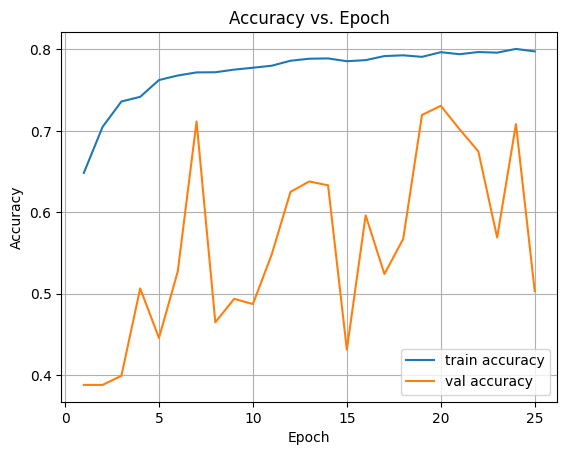

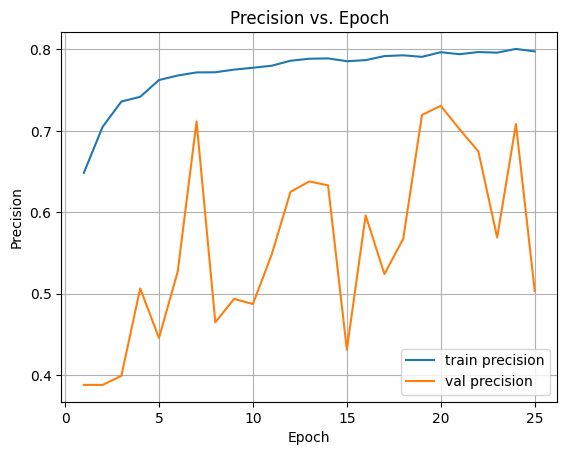

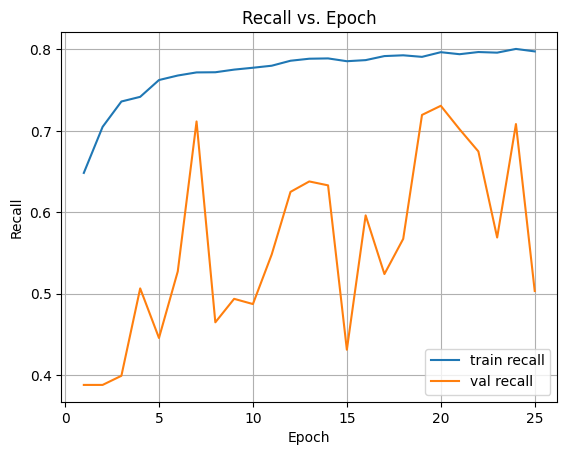

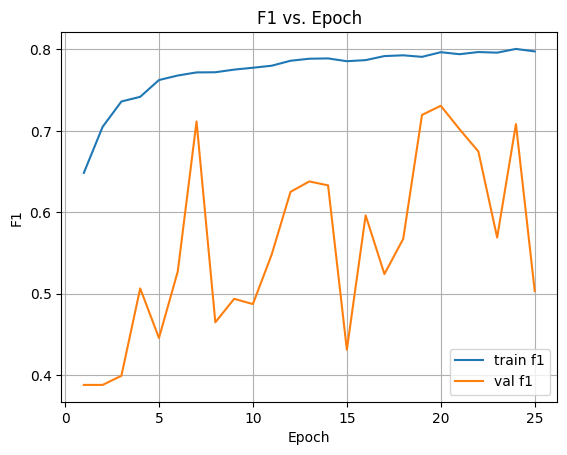

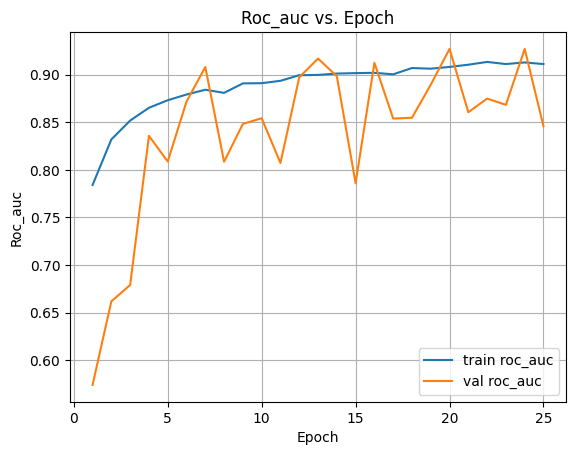

In [26]:
epochs = range(1, 26)
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plt.figure()
    plt.plot(epochs, history.history[metric],         label=f"train {metric}")
    plt.plot(epochs, history.history[f"val_{metric}"], label=f"val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} vs. Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# Использование предобученной модели

In [74]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    seed=42,
    color_mode="rgb",           # MobileNet ждёт 3-канальный ввод
    image_size=IMG_SIZE,
    label_mode="categorical"    # one-hot
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    seed=42,
    color_mode="rgb",
    image_size=IMG_SIZE,
    label_mode="categorical"
)

preprocess_layer   = tf.keras.layers.Lambda(preprocess_input)  # из MobileNetV2
data_aug_layer     = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomRotation(0.05, seed=42),
])

base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = True    # фаза 1: полностью заморожена
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = tf.keras.Sequential([
    data_aug_layer,
    preprocess_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        OneHotPrecision(NUM_CLASSES),
        OneHotRecall(NUM_CLASSES),
        F1Score(NUM_CLASSES),
        tf.keras.metrics.AUC(
            multi_label=True,
            num_labels=NUM_CLASSES,
            name="roc_auc")
    ]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25
)

model.summary()

Found 5232 files belonging to 3 classes.
Found 624 files belonging to 3 classes.
Epoch 1/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6932 - f1: 0.6932 - loss: 0.9062 - precision: 0.6932 - recall: 0.6932 - roc_auc: 0.8327 - val_accuracy: 0.6651 - val_f1: 0.6651 - val_loss: 2.1237 - val_precision: 0.6651 - val_recall: 0.6651 - val_roc_auc: 0.8492
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7869 - f1: 0.7869 - loss: 0.5264 - precision: 0.7869 - recall: 0.7869 - roc_auc: 0.9019 - val_accuracy: 0.7724 - val_f1: 0.7724 - val_loss: 0.8664 - val_precision: 0.7724 - val_recall: 0.7724 - val_roc_auc: 0.9287
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8081 - f1: 0.8081 - loss: 0.4598 - precision: 0.8081 - recall: 0.8081 - roc_auc: 0.9169 - val_accuracy: 0.7356 - val_f1: 0.7356 - val_loss: 1.1589 - val_precision: 0.7356 - val_recall: 0.7356 - val_roc_auc: 0.9009
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8243 - f1

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_40 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,658,315 (21.58 MB)

 Trainable params: 1,535,299 (5.86 MB)

 Non-trainable params: 1,052,416 (4.01 MB)

 Optimizer params: 3,070,600 (11.71 MB)

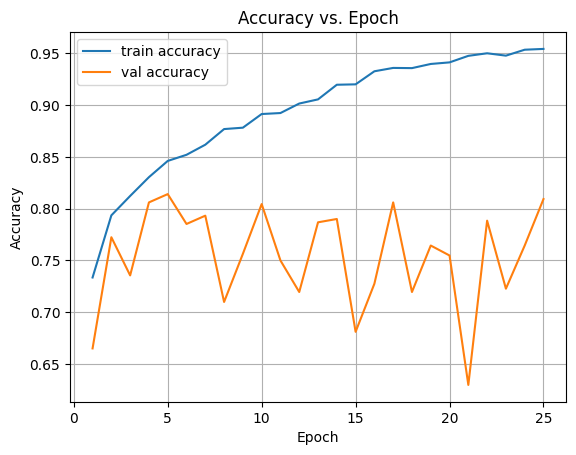

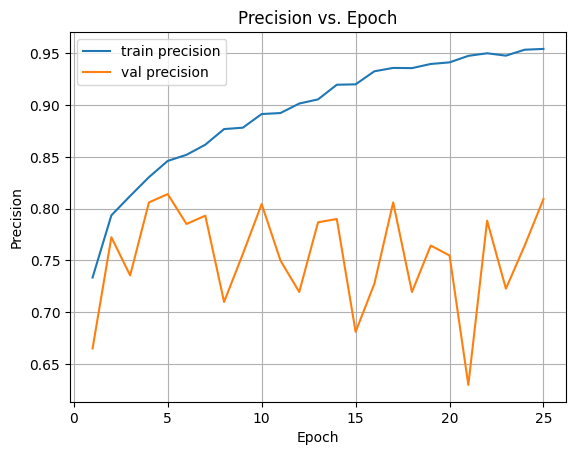

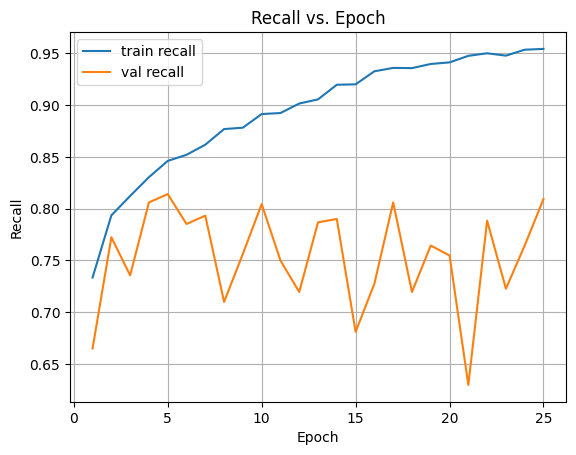

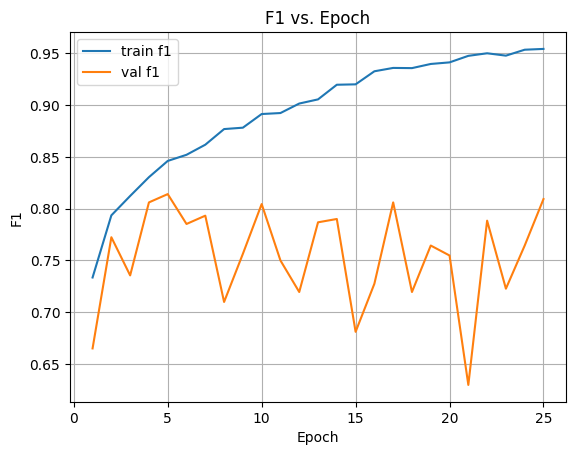

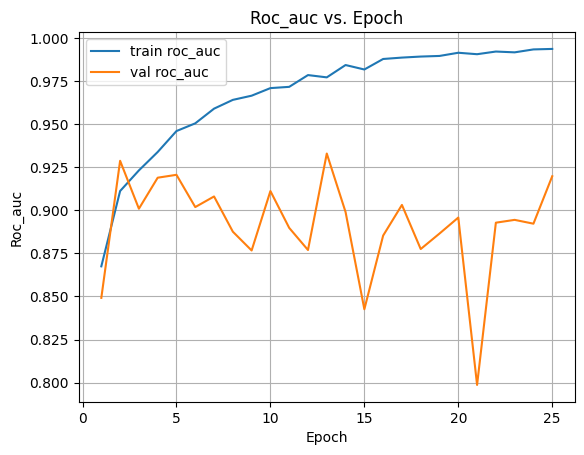

In [75]:
epochs = range(1, 26)
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plt.figure()
    plt.plot(epochs, history.history[metric],         label=f"train {metric}")
    plt.plot(epochs, history.history[f"val_{metric}"], label=f"val {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} vs. Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()